In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [2]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2020-07-22 13:43:26--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.39.36.120, 2600:1407:f800:49b::e59, 2600:1407:f800:4a5::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.39.36.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   199MB/s    in 4.0s    

2020-07-22 13:43:30 (194 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [4]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [5]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [6]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [8]:
# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=100,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(150, 150),
        batch_size=100,
        class_mode='binary')

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [10]:
history = model.fit(
      train_generator,
      epochs=15,
      validation_data=validation_generator,
      verbose=2)

Epoch 1/15


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 - 190s - loss: 0.7648 - acc: 0.5765 - val_loss: 0.6615 - val_acc: 0.5856
Epoch 2/15
225/225 - 193s - loss: 0.6164 - acc: 0.6591 - val_loss: 0.5387 - val_acc: 0.7188
Epoch 3/15
225/225 - 186s - loss: 0.5782 - acc: 0.6956 - val_loss: 0.5199 - val_acc: 0.7544
Epoch 4/15
225/225 - 191s - loss: 0.5487 - acc: 0.7181 - val_loss: 0.5094 - val_acc: 0.7592
Epoch 5/15
225/225 - 196s - loss: 0.5309 - acc: 0.7331 - val_loss: 0.4886 - val_acc: 0.7624
Epoch 6/15
225/225 - 187s - loss: 0.5230 - acc: 0.7396 - val_loss: 0.4466 - val_acc: 0.8036
Epoch 7/15
225/225 - 186s - loss: 0.5049 - acc: 0.7534 - val_loss: 0.4513 - val_acc: 0.7852
Epoch 8/15
225/225 - 188s - loss: 0.4935 - acc: 0.7610 - val_loss: 0.4913 - val_acc: 0.7628
Epoch 9/15
225/225 - 193s - loss: 0.4873 - acc: 0.7642 - val_loss: 0.4105 - val_acc: 0.8112
Epoch 10/15
225/225 - 193s - loss: 0.4771 - acc: 0.7735 - val_loss: 0.4283 - val_acc: 0.7928
Epoch 11/15
225/225 - 190s - loss: 0.4692 - acc: 0.7784 - val_loss: 0.3976 - val_acc: 0.81

**Train vs Validation Accuracy and Loss Plot**

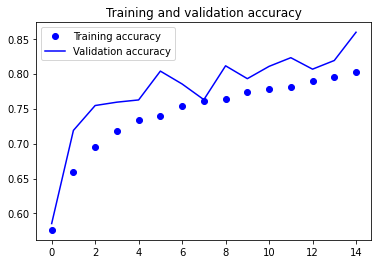

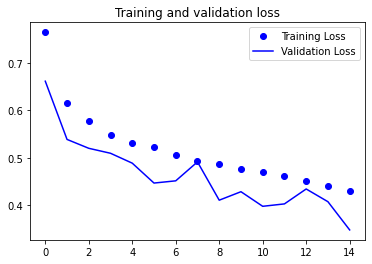

In [11]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Using TensorFlow backend.


Saving cat.jpg to cat.jpg
Saving Cat2.jpg to Cat2.jpg
Saving Cat3.jpg to Cat3.jpg
Saving cat4.png to cat4.png
Saving cat5.webp to cat5.webp
Saving dog.jpg to dog.jpg
Saving dog2.jpg to dog2.jpg
Saving Dog3.jpg to Dog3.jpg
Saving dog4.jpg to dog4.jpg
Saving dog5.jpg to dog5.jpg
[1.]
cat.jpg is a dog
[4.334322e-28]
Cat2.jpg is a cat
[1.]
Cat3.jpg is a dog
[1.]
cat4.png is a dog
[0.]
cat5.webp is a cat
[1.]
dog.jpg is a dog
[1.]
dog2.jpg is a dog
[1.]
Dog3.jpg is a dog
[1.]
dog4.jpg is a dog
[1.]
dog5.jpg is a dog
